# Project: Interpolation using Neural Networks
The first part of this notebook, reads the data (generated by finite differences in a separate program). From the point indicated "needs editing from here", there is a complete dataflow to do interpolation. The actual classes required are not given, and they are the project itself.

Notice: don't need to follow this dataflow. It is just supplied to give you a guide.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def normalize(data, scale=1):
    mean=data.mean()
    std=data.std()*scale
    data=(data-mean)/std
    return data

In [7]:
# Loading and reshape data
nt=719
ng=396
ns=80
ntr=ns*ng

temp0 = np.fromfile("shotsallr0.bin",dtype = np.float32 )
temp1 = temp0.reshape((nt,ntr),order='F')
data0 = np.reshape(temp1,(nt,ng,ns),order='F')
temp0 = np.fromfile("shotsallr1.bin",dtype = np.float32 )
temp1 = temp0.reshape((nt,ntr),order='F')
data1 = np.reshape(temp1,(nt,ng,ns),order='F')
signal = data0-data1


In [9]:
print(data0.shape, data1.shape,signal.shape) #let us know the shape

(719, 396, 80) (719, 396, 80) (719, 396, 80)


In [16]:
def plot(nshots,fshot,dshots,data):
    #Select first slice seismic data and plot
    fig,ax=plt.subplots(nrows=1,ncols=nshots,figsize=(20,5))
    for i in range(nshots):
        shot = data[:,:,fshot+i*dshots]
        shot=normalize(shot)    
        ax[i].imshow(shot,vmin=-1,vmax=1,cmap='seismic',aspect='auto')
        ax[i].set_xlabel("In-line number", fontsize=10)
        ax[i].set_ylabel("Time (ms)", fontsize=10)
        ax[i].set_title("Seismic Section")

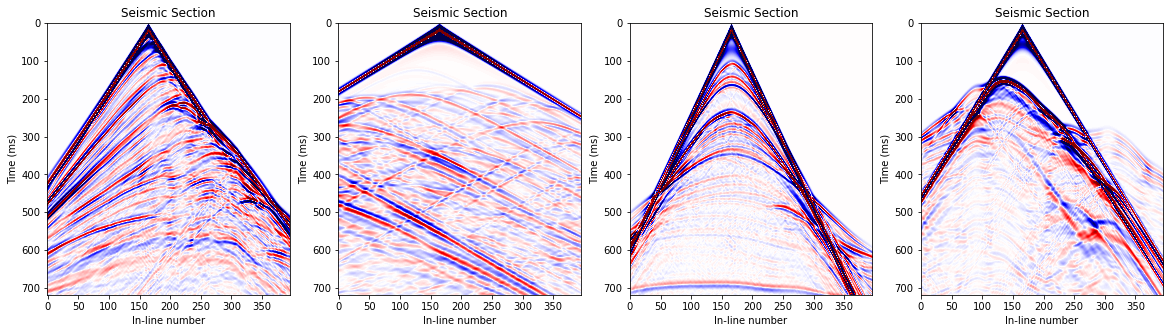

In [17]:
plot(4,0,20,data0)

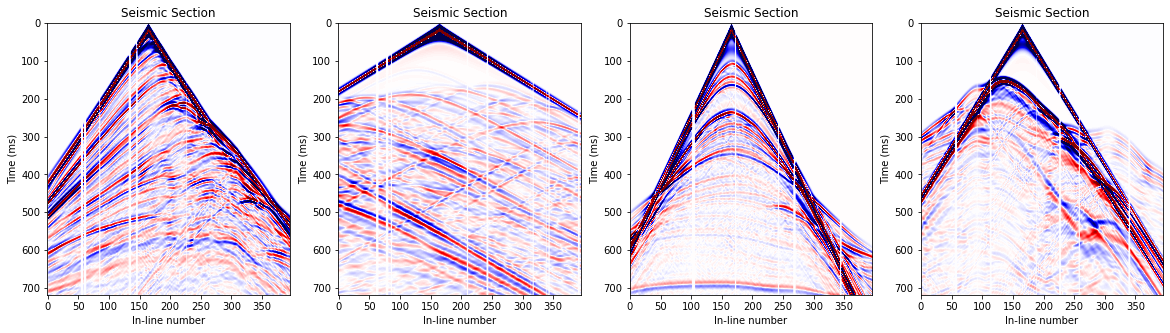

In [18]:
plot(4,0,20,data1)

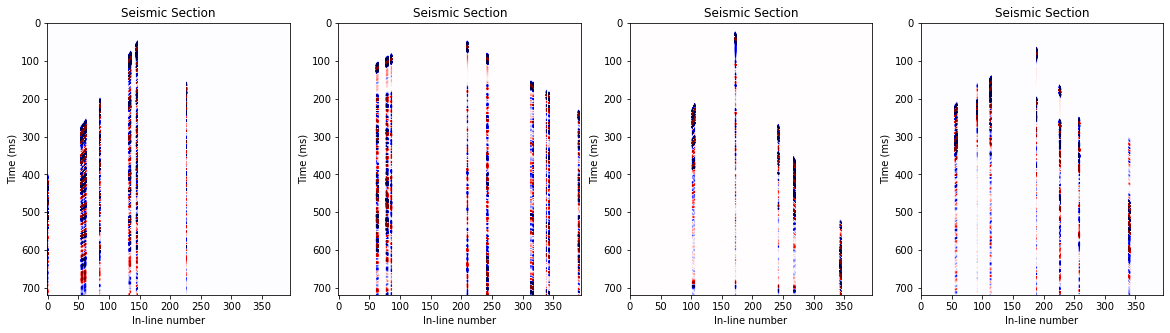

In [19]:
plot(4,0,20,signal)

Needs editing from this point

In [8]:
import sys
import m8r
import numpy as np
import tensorflow as tf
import copy, time
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import load_model, save_model
from imp import reload
from classes import Autoencoder28, AutoEncoder56, Unet
from classes import Windowing
from functions import getcallbacks, getsavemodel, normalize, scaling_perc 
from functions import plot_pred, plot_image, PlotPatch, plot_history, plot_predunet
from functions2 import readrsffiles, readrsfile, testreconstruction, getpatch, getpatchb, padwithorig2 

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
# this code can be used to switch gpus. The default gpu (0) is the most powerful (it seems)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-06-09 11:59:35.758141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-09 11:59:36.576287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6


In [4]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [11]:
# parameters
MLrun=True
window=64
nchannels=1
input='shotsallr1.rsf'
label='shotsallr0.rsf'
outname='shotsint.rsf'

In [6]:
inp=m8r.Input(input)
inplabel=m8r.Input(label)

In [7]:
trlen,numtr,numsh,d1=readrsffiles(inp,inplabel)
data0=readrsfile(inp,trlen,numtr,numsh)
label0=readrsfile(inplabel,trlen,numtr,numsh)

input 1 shape 17025920 23680 80
input 2 shape 17025920 23680 80


In [8]:
print(data0.shape)
print(label0.shape)

(80, 296, 719)
(80, 296, 719)


In [9]:
data0b=normalize(data0)
label0b=normalize(label0)

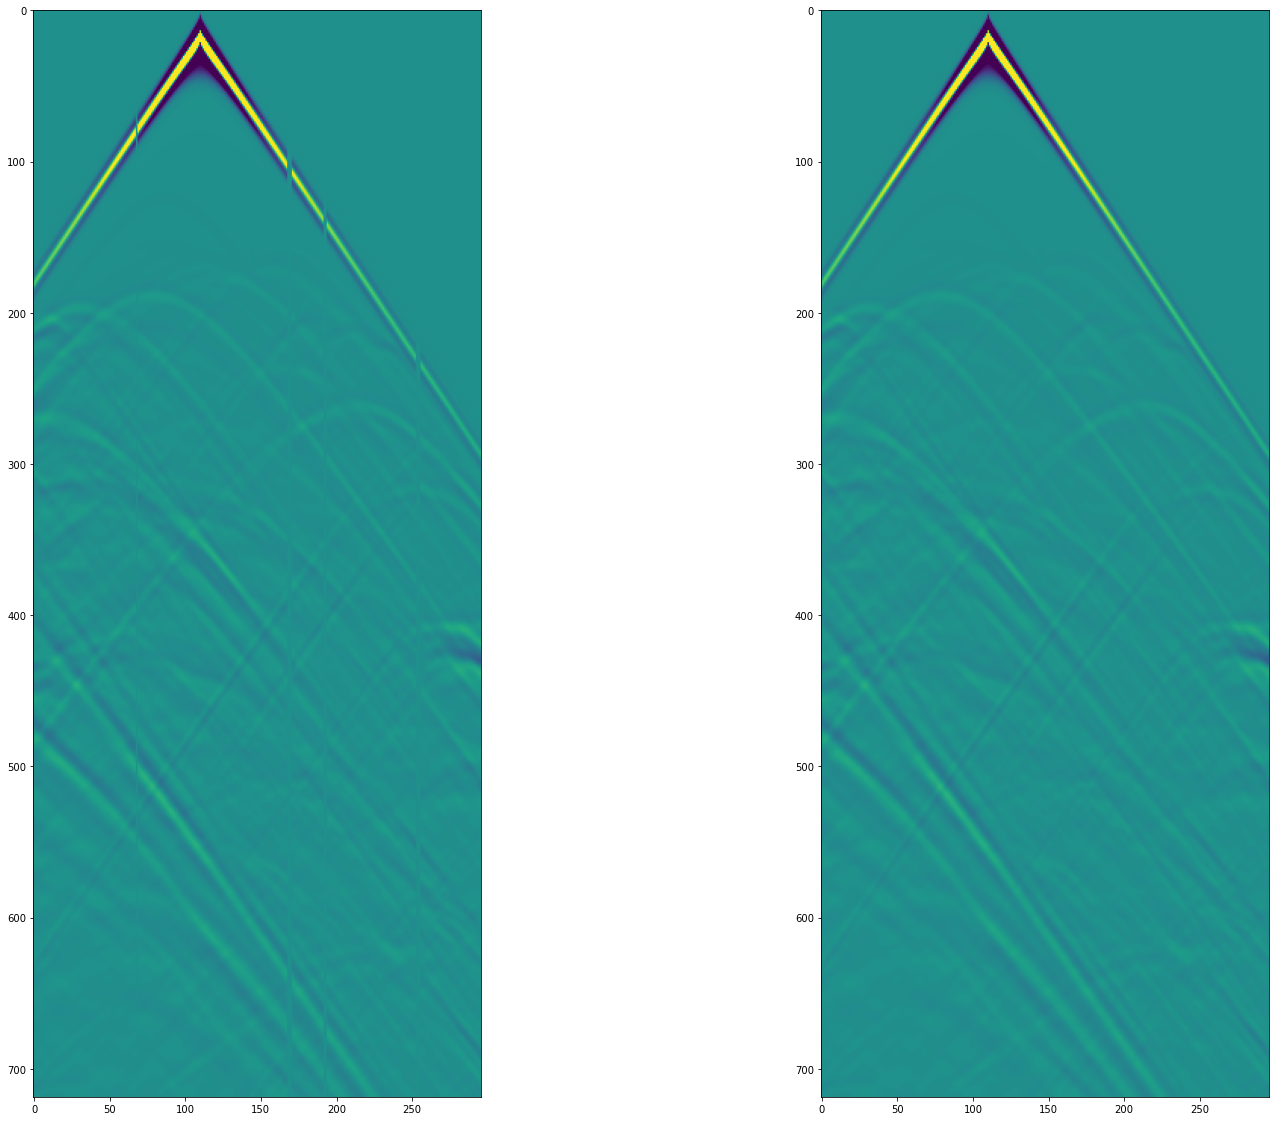

In [10]:
testid=int(numsh/2)
pclip = 99
data0b=scaling_perc(data0b,pclip)
label0b=scaling_perc(label0b,pclip)
fig=plt.figure(figsize=(40,20))
plt.subplot(131);plt.imshow(data0b[testid].T)
plt.subplot(132);plt.imshow(label0b[testid].T)


In [12]:
wind = Windowing(window)

In [13]:
data0b.shape

(80, 296, 719)

In [14]:
testid=10
shotrecon=testreconstruction(data0b,wind,number=testid);

(1, 296, 719)
patchin shape (55, 64, 64)
nrows= 4 ncols= 11
shotpred shape (1, 256, 694)


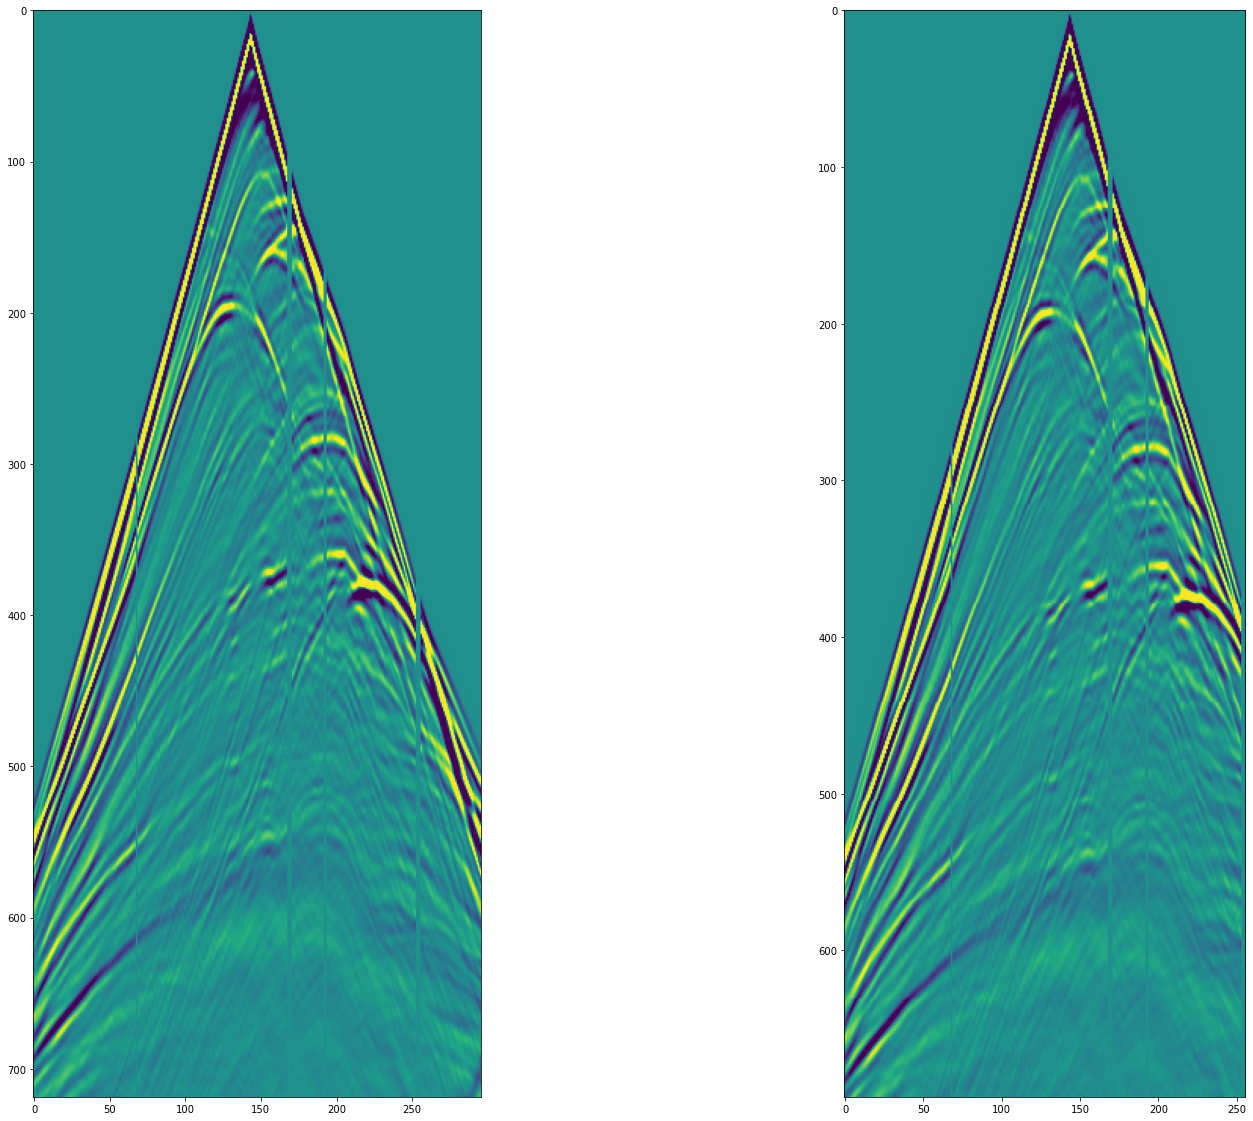

In [15]:
fig=plt.figure(figsize=(40,20))
plt.subplot(131);plt.imshow(data0b[testid].T)
plt.subplot(132);plt.imshow(shotrecon.T)

In [16]:
## write a windowing function here (needs 3 input)
train =wind.shot2patch(data0b)
labels =wind.shot2patch(label0b)
print('train shape',train.shape)

80 296 719
80 296 719
train shape (14080, 64, 64)


In [17]:
train, labels = wind.removezeroes(train,labels)

12028 nonzero from  14080


In [18]:
n1,n2,n3=train.shape
train2=np.zeros(shape=(n1,n2,n3,nchannels))
train2[:,:,:,0]=train
print(train2.shape)


(12028, 64, 64, 1)


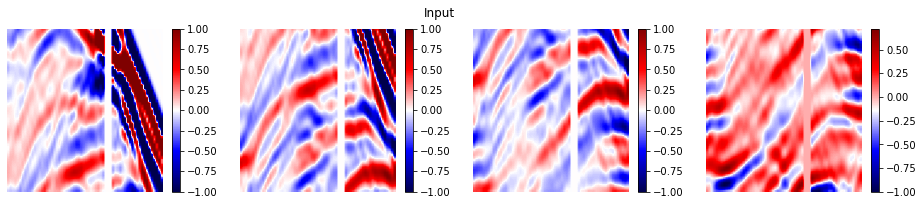

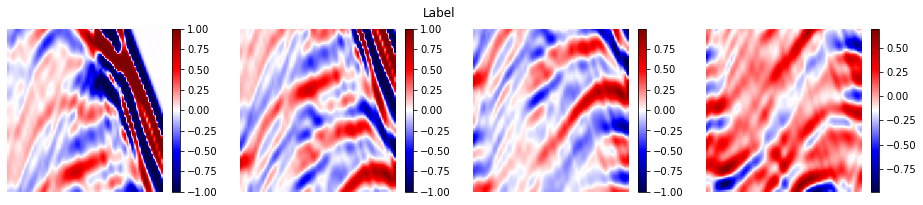

In [19]:
PlotPatch(train2[89:,:,:,0],1,4,'Input')
PlotPatch(labels[89:,:,:],1,4,'Label')

In [20]:
dotrain=1
MLrun=True  # set to False to test I/O
MLtrain=True
MLrestart=True
if dotrain==0:
    MLtrain=False # if true do training, otherwise just predict
    MLrestart=False
elif dotrain==1:
    MLtrain=True
    MLrestart=False
elif dotrain==2:
    MLtrain=True
    MLrestart=True

In [21]:
# Alternative version callback 2 with val_snr
from functions2 import snr # custom function for SignalToNoise metric
from classes2 import Resnet
from classes2 import UnetBook
dnet=1
if (dnet==1):
    optioncallback=2
    net='unet'
elif (dnet==2):
    optioncallback=2
    net='resn'

input_size = (window, window, nchannels)

In [22]:
if MLrun:
    if window==28:
        model=Autoencoder28(window)
    elif window==56:
        model=AutoEncoder56(window)
    elif window==64:
        if (net=='unet'): model=Unet(input_size=input_size)
        if (net=='resn'): model=Resnet(input_size=input_size)
    elif window==128:
        if (net=='unet'): model=UnetBook(input_size=input_size, name='imag')
        if (net=='resn'): model=Resnet(input_size=input_size)
    else:
        pass    
    

    if (MLrestart):
        model=load_model(getsavemodel(window,nchannels=nchannels))

    if (MLtrain):
        if (MLrestart==False):
            if (optioncallback==1):
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        loss = keras.losses.MeanSquaredError(), metrics=['MSE'])
                print('restarting weights with callback option 1')
            elif (optioncallback==2):
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        loss = keras.losses.MeanSquaredError(), metrics=[snr])
                print('restarting weights with callback option 2')


        level=2
        callbacks=getcallbacks(window,level,nchannels=nchannels,option=optioncallback)
        model.build(input_shape=[None,window,window,nchannels])
        model.summary()
        


restarting weights with callback option 2
Model: "unet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 64, 64, 1)         3839841   
Total params: 3,839,841
Trainable params: 3,835,937
Non-trainable params: 3,904
_________________________________________________________________


In [23]:
if MLtrain:
    t_start = time.time()
    history = model.fit(x=train2, y=labels, batch_size=32, epochs=20,
                validation_split=0.2, shuffle=True, verbose=2,
                callbacks=callbacks)
    t_end = time.time()
    print(f"Run time = {(t_end-t_start)/60} minutes")

2022-06-09 12:01:06.557855: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-06-09 12:01:09.074764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


301/301 - 15s - loss: 0.0111 - snr: 11.2602 - val_loss: 0.0020 - val_snr: 7.5673

Epoch 00001: val_snr improved from -inf to 7.56730, saving model to ./model/AE_trained_v3_1.model


2022-06-09 12:01:24.953546: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model/AE_trained_v3_1.model/assets
Epoch 2/20
301/301 - 6s - loss: 0.0026 - snr: 13.8573 - val_loss: 5.7275e-04 - val_snr: 14.1272

Epoch 00002: val_snr improved from 7.56730 to 14.12721, saving model to ./model/AE_trained_v3_1.model
INFO:tensorflow:Assets written to: ./model/AE_trained_v3_1.model/assets
Epoch 3/20
301/301 - 6s - loss: 0.0024 - snr: 14.2778 - val_loss: 4.8387e-04 - val_snr: 14.7957

Epoch 00003: val_snr improved from 14.12721 to 14.79569, saving model to ./model/AE_trained_v3_1.model
INFO:tensorflow:Assets written to: ./model/AE_trained_v3_1.model/assets
Epoch 4/20
301/301 - 6s - loss: 0.0021 - snr: 14.6975 - val_loss: 4.3011e-04 - val_snr: 14.9643

Epoch 00004: val_snr improved from 14.79569 to 14.96426, saving model to ./model/AE_trained_v3_1.model
INFO:tensorflow:Assets written to: ./model/AE_trained_v3_1.model/assets
Epoch 5/20
301/301 - 6s - loss: 0.0017 - snr: 15.7881 - val_loss: 6.0983e-04 - val_snr: 11.8094

Epoch 00005: val

In [24]:
if (optioncallback==1):
    model=load_model(getsavemodel(window,nchannels=nchannels))
elif (optioncallback==2):
    model=load_model(getsavemodel(window,nchannels=nchannels),custom_objects={'snr':snr},compile=True)

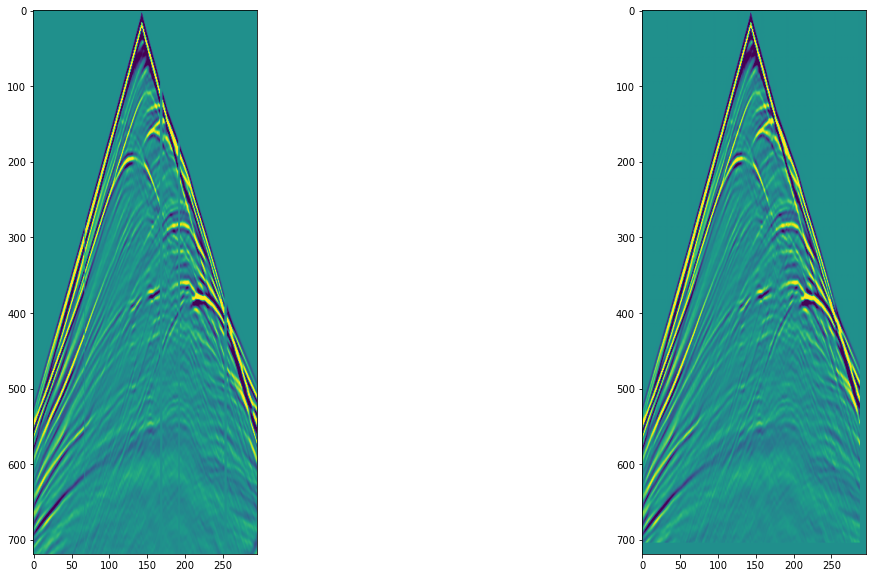

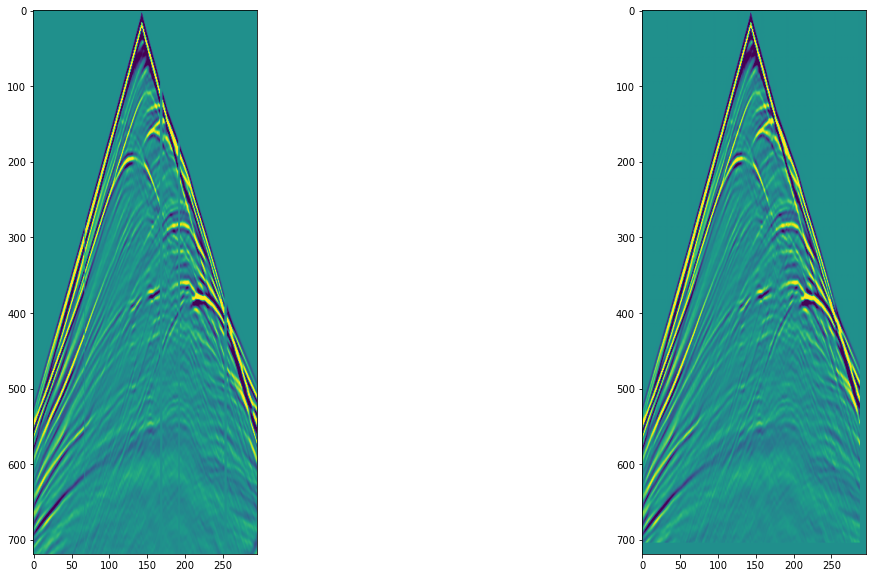

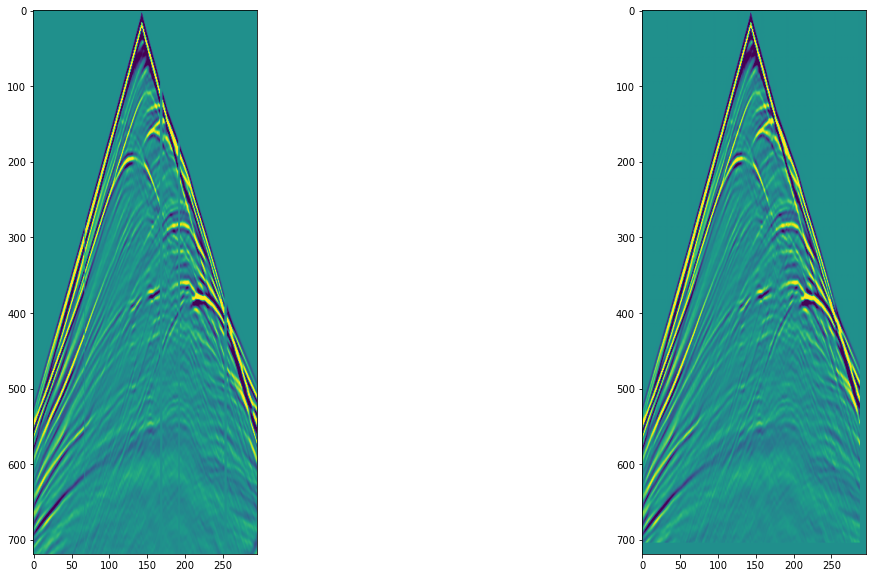

In [25]:
for id in range(0,21,10):
    patchin = getpatchb(data0b,None,None,testid,wind,nchannels)
    patchout = model.predict(patchin)
    patchout=patchout[:,:,:,0]
    # define output shape 
    shotpred = wind.patch2shot_predb(patchout)
    plt.figure(figsize=(20,10))
    plt.subplot(121),plt.imshow(data0b[testid:testid+1,:,:].T)
    plt.subplot(122),plt.imshow(shotpred[0,:,:].T)
    
    

In [26]:
shotpred.shape

(1, 296, 719)

dict_keys(['loss', 'snr', 'val_loss', 'val_snr', 'lr'])


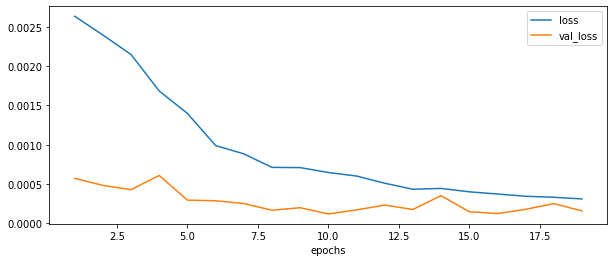

In [27]:
if MLtrain:
    plot_history(history)

dict_keys(['loss', 'snr', 'val_loss', 'val_snr', 'lr'])


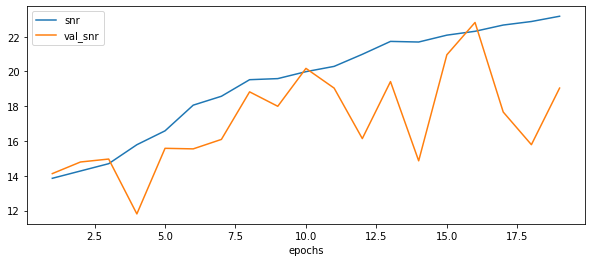

In [28]:
import matplotlib.pyplot as plt
iter=history.epoch
print(history.history.keys())
plt.figure(figsize=(10,4))
plt.subplot(111)   
plt.plot(iter[1:],history.history['snr'][1:],label='snr')
plt.plot(iter[1:],history.history['val_snr'][1:],label='val_snr')
plt.xlabel('epochs')
plt.legend()